# Приоритизация гипотез и анализ A/B-теста для интернет-магазина.

**Заказчик** — крупный интернет-магазин.

**Цель:** Приоритизировать гипотезы для увеличения выручки, запустить A/B-тест и проанализировать результаты. 

**Входные данные:** Файл /datasets/hypothesis.csv с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Результаты A/B-теста, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

**Описание данных:**

* Файл /datasets/hypothesis.csv. содержит: <br/>
`Hypothesis` — краткое описание гипотезы; <br/>
`Reach` — охват пользователей по 10-балльной шкале; <br/>
`Impact` — влияние на пользователей по 10-балльной шкале; <br/>
`Confidence` — уверенность в гипотезе по 10-балльной шкале; <br/>
`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы. <br/>

* Файл /datasets/orders.csv. содержит: <br/>
`transactionId` — идентификатор заказа; <br/>
`visitorId` — идентификатор пользователя, совершившего заказ; <br/>
`date` — дата, когда был совершён заказ; <br/>
`revenue` — выручка заказа; <br/>
`group` — группа A/B-теста, в которую попал заказ. <br/>

* Файл /datasets/visitors.csv. содержит: <br/>
`date` — дата; <br/>
`group` — группа A/B-теста; <br/>
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

<a id="enter"></a>
**Содержание:**

1. [Рассмотрение и обработка данных.](#start)
    * [1.1 Данные для 9 гипотез по увеличению выручки магазина](#hip)
    * [1.2 Данные данные о заказах в группах А и В](#ord)
    * [1.3 Данные о посещениях в группах А и В](#vis)
    * [1.4 Проверка данных на дубликаты и пересечения](#dup)
2. [Приоритизация гипотез](#prior)
    * [2.1 Приоритизация гипотез c применением фреймворка ICE](#ice)
    * [2.2 Приоритизация гипотез c применением фреймворка RICE](#rice)
3. [Анализ А/В теста](#ab)
    * [3.1 Построение графика кумулятивной выручки](#crev)
    * [3.2 Построение кумулятивного графика среднего чека по группам](#bill)
    * [3.3 График относительного изменения кумулятивного среднего чека группы B к группе A]('bill_rate')
    * [3.4 График кумулятивного среднего количества заказов на посетителя по группам]('mean_ord')
    * [3.5 График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A]('mean_ord_prop')
    * [3.6 Точечный график количества заказов по пользователям]('scatter')
    * [3.7 Расчет 95-й и 99-й перцентили количества заказов на пользователя]('perc_ord')
    * [3.8 Точечный график стоимостей заказов]('scatt_rev')
    * [3.9 Расчет 95-й и 99-й перцентили стоимости заказов]('perc_rev')
    * [3.10 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным]('ord_mwraw')
    * [3.11 Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным]('bill_mwraw')
    * [3.12 Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным]('ord_mwfilter')
    * [3.13 Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным]('bill_mwfilter')
4. [Выводы](#conclusion)

In [1]:
# импорт библиотек 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt
import scipy.stats as stats

<a id='start'></a>
## Рассмотрение и обработка данных.

<a id='hip'></a>
###  Данные для 9 гипотез по увеличению выручки магазина

Начнем анализ с рассмотрения гипотез. Для этого прочтем файл `hypothesis.csv` и изучим его содержимое.

In [2]:
hypothesis=pd.read_csv('hypothesis.csv')

In [3]:
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
display(set(hypothesis['Hypothesis']))

{'Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа',
 'Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей',
 'Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов',
 'Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок',
 'Запустить акцию, дающую скидку на товар в день рождения',
 'Запустить собственную службу доставки, что сократит срок доставки заказов',
 'Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар',
 'Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей',
 'Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию'}

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Итак, таблица состоит из 9 строк и 5 столбцов. Названия гипотез имеют общий формат. Столбцы ICE и RICE имеют формат float64, остальные формат int64. 

[к содержанию](#enter)

<a id='ord'></a>
### Данные данные о заказах в группах А и В

Раскроем файл с информацией о заказах.

In [6]:
orders=pd.read_csv('orders.csv')

In [7]:
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Датасет состоит из 1197 строк и 5 столбцов. Столбцы `transactionId`, `visitorId` и `revenue` имеют формат int64, а `date` и `group` имеют формат object. Поскольку в столбце `date` указано время заказа, исправим его формат на соответствующий.                                      

In [9]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
display(orders['date'].sort_values())

168    2019-08-01
73     2019-08-01
72     2019-08-01
71     2019-08-01
70     2019-08-01
          ...    
1021   2019-08-31
1022   2019-08-31
1023   2019-08-31
995    2019-08-31
959    2019-08-31
Name: date, Length: 1197, dtype: datetime64[ns]

Данные столбца `date` говорят о том, что исследуемый период с 2019-08-01 по 2019-08-31.

[к содержанию](#enter)

<a id='vis'></a>
### Данные о посещениях в группах А и В

Рассмотрим датасет с информацией о числе посещений.

In [11]:
visits=pd.read_csv('visitors.csv')

In [12]:
display(visits.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Таблица состоит из 62 строк и 3 столбцов. Формат столбца `visitors` int64, остальных - object. Приведем столбец `date` к нужному формату. 

In [14]:
visits['date'] = visits['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Число строк по каждой из групп соотвествует рассматриваемому периоду и равно числу дней. 

In [15]:
print('Число строк для группы А', visits[visits['group']=='A']['group'].count())
print('Число строк для группы B', visits[visits['group']=='B']['group'].count())

Число строк для группы А 31
Число строк для группы B 31


<a id='dup'></a>
### Проверка данных на дубликаты и пересечения

Проверим есть ли явные дубликаты

Датасет `orders`

In [16]:
orders.duplicated().unique()

array([False])

Датасет `visits`

In [17]:
visits.duplicated().unique()

array([False])

Явных дубликатов нет. Проверим есть ли неявные дубликаты

In [18]:
orders['transactionId'].nunique()

1197

In [19]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [20]:
visits['group'].unique()

array(['A', 'B'], dtype=object)

Неявных дубликатов также нет.

Проверим есть ли пересечение пользователей по группам

In [21]:
uniq_userA=orders.query('group=="A"')['visitorId'].unique()
userAB=orders.query('group=="B" & (visitorId in @uniq_userA)')['visitorId']
print(userAB.count())

92


Как видно в заказах есть 92 строки где один и тот же пользователь входит в обе группы. Удалим эти строки.

In [22]:
orders=orders.query('visitorId not in @userAB')
display('Число непересекающихся строк:', orders['visitorId'].count())

'Число непересекающихся строк:'

1016

[к содержанию](#enter)

<a id='prior'></a>
## Приоритизация гипотез.

<a id='ice'></a>
### Приоритизация гипотез c применением фреймворка ICE

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета. В соответствии с методом ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») показатель приоритета определяется: `Impact` x `Confidence`/ `Efforts`.

In [23]:
hypothesis['ICE']=hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']

In [24]:
pd.options.display.max_colwidth = 400
display(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наибольший приоритет 16.2 у гипотезы `Запустить акцию, дающую скидку на товар в день рождения`, далее 13.3 балла у гипотезы `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`. На третьем месте гипотеза `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` - 11.2 балла.

[к содержанию](#enter)

<a id='rice'></a>
### Приоритизация гипотез c применением фреймворка RICE

Применим фреймворк RICE для приоритизации гипотез и отсортируем их по убыванию приоритета. В соответствии с методом RICE (от англ. reach, impact, confidence, effort / ease «охват, влияние, уверенность, усилия / простота») показатель приоритета определяется: `Reach` x `Impact` x `Confidence`/ `Efforts`.

In [25]:
hypothesis['RICE']=hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']

In [26]:
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Как видно добавление параметра Reach поменяло распределение гипотез, что вполне объяснимо, ведь например `Запустить акцию, дающую скидку на товар в день рождения` имеет очень узкий охват, а если `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` то это затронет всех пользователей. Поэтому наибольший приоритет 112 - у гипотезы `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок`, далее 56 баллов у гипотезы `Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа`. На третьем месте гипотеза `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`  - 40 баллов.

**Вывод:** Из 9-ти гипотез наиболее приоритетными выбрем `Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок` и `Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей`.

[к содержанию](#enter)

<a id='ab'></a>
## Анализ А/В теста.

<a id='crev'></a>
### Построение графика кумулятивной выручки

Для построения графика кумулятивной выручки подготовим данные. В таблице `orders` cоздадим уникальную комбинацию столбцов даты и группы. Далее сложим выручку с нарастанием по дням, а затем разделим таблицу по группам А и В.

In [27]:
dategroups=orders[['date', 'group']].drop_duplicates()

In [28]:
ordersCumulative= dategroups.apply(lambda x: orders[np.logical_and(orders['date']<=x['date'], orders['group']==x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [29]:
ordersCumulative.columns=['date', 'group', 'orders', 'buyers', 'revenue']

In [30]:
ordersCumulativeA = ordersCumulative[ordersCumulative['group']=='A'][['date', 'orders', 'buyers', 'revenue']]
ordersCumulativeB = ordersCumulative[ordersCumulative['group']=='B'][['date', 'orders', 'buyers', 'revenue']]

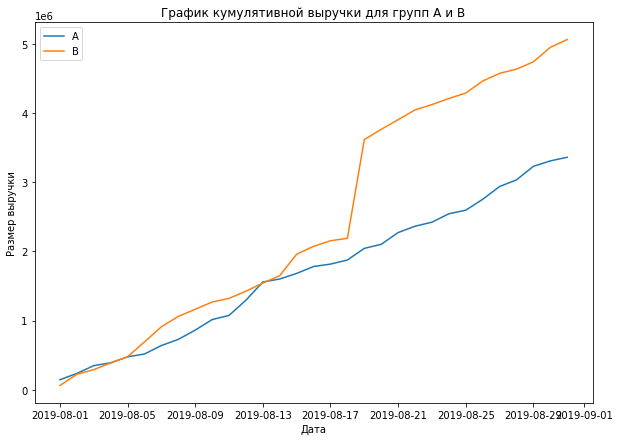

In [31]:
plt.figure(figsize=(10,7))
# Строим график выручки группы А
plt.plot(ordersCumulativeA['date'], ordersCumulativeA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(ordersCumulativeB['date'], ordersCumulativeB['revenue'], label='B')

plt.legend()
plt.title('График кумулятивной выручки для групп А и В')
plt.xlabel('Дата')
plt.ylabel('Размер выручки');

Как видно из графика до 13.08 разрыв в выручке в группах В и А то уменьшался, то увеличивался. Далее разница между В и А растет, особенно после скачка в районе 19-20.08 (возможно повлияли выбросы).

[к содержанию](#enter)

<a id='bill'></a>
### Построение кумулятивного графика среднего чека по группам

Сравним размеры средних чеков в группах, для чего разделим общую выручку на число заказов.

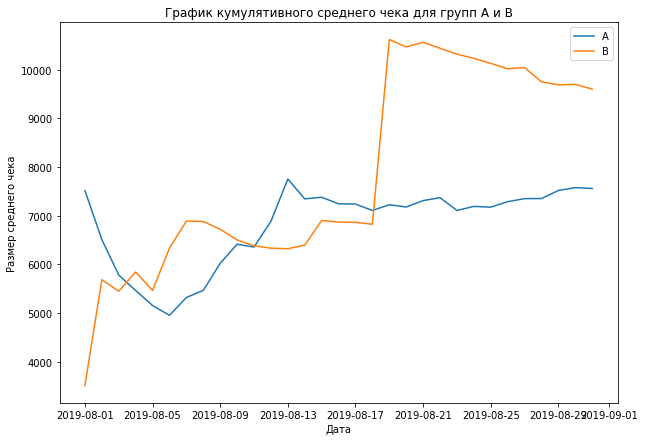

In [32]:
plt.figure(figsize=(10,7))
# Строим график выручки группы А
plt.plot(ordersCumulativeA['date'], ordersCumulativeA['revenue']/ordersCumulativeA['buyers'], label='A')

# Строим график выручки группы B
plt.plot(ordersCumulativeB['date'], ordersCumulativeB['revenue']/ordersCumulativeB['buyers'], label='B')

plt.legend()
plt.title('График кумулятивного среднего чека для групп А и В')
plt.xlabel('Дата')
plt.ylabel('Размер среднего чека');

Средний чек имеет большие колебания в обеих группах. в группе В к концу периода разрыв после скачка 19-20.08 особенно заметен (не исключено что выбросы).

[к содержанию](#enter)

<a id='bill_rate'></a>
### График относительного изменения кумулятивного среднего чека группы B к группе A.

Рассмотрим как соотносится средний чек в группах (изменение чека разделим на средний чек в группе А).

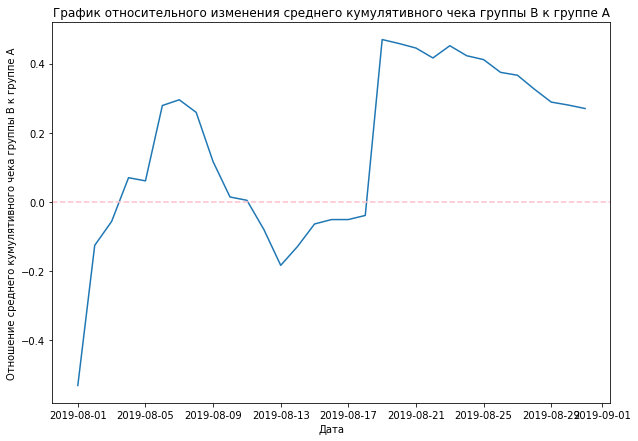

In [33]:
plt.figure(figsize=(10,7))
orders_merged=ordersCumulativeA.merge(ordersCumulativeB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(orders_merged['date'], (orders_merged['revenueB']/orders_merged['buyersB'])/(orders_merged['revenueA']/orders_merged['buyersA'])-1)
plt.axhline(y=0, color='pink', linestyle='--')
plt.title('График относительного изменения среднего кумулятивного чека группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего кумулятивного чека группы В к группе А');

Из графика видно, что вначале наблюдался более чем 50% разрыв (группа В ниже чем A). Затем до 7 августа отношение В к А сокращалось, и потом в В средний чек стал выше на 30%. Далее резкое падение до -20%, а затем рост и резкий скачок до 45% и падение до 25%. Картина крайне нестабильна и требует проверки данных на выбросы.

[к содержанию](#enter)

<a id='mean_ord'></a>
### График кумулятивного среднего количества заказов на посетителя по группам.

Найдем кумулятивное число посетителей и объединим их с кумулятивной таблицей заказов.

In [34]:
visitorsA = visits[visits['group']=='A']
visitorsB = visits[visits['group']=='B']

In [35]:
visitorsACumulative=visitorsA.apply(lambda x: visitorsA[visitorsA['date']<=x['date']].agg(
    {'date':'max', 'visitors':'sum'}), axis=1)
visitorsBCumulative=visitorsA.apply(lambda x: visitorsA[visitorsA['date']<=x['date']].agg(
    {'date':'max', 'visitors':'sum'}), axis=1)

In [36]:
visit_merged=visitorsACumulative.merge(visitorsBCumulative, left_on='date', right_on='date', suffixes=['A', 'B'])

In [37]:
ord_vis_merged=orders_merged.merge(visit_merged, left_on='date', right_on='date', how='left')

In [38]:
ord_vis_merged['conversionA']=ord_vis_merged['ordersA']/ord_vis_merged['visitorsA']
ord_vis_merged['conversionB']=ord_vis_merged['ordersB']/ord_vis_merged['visitorsB']

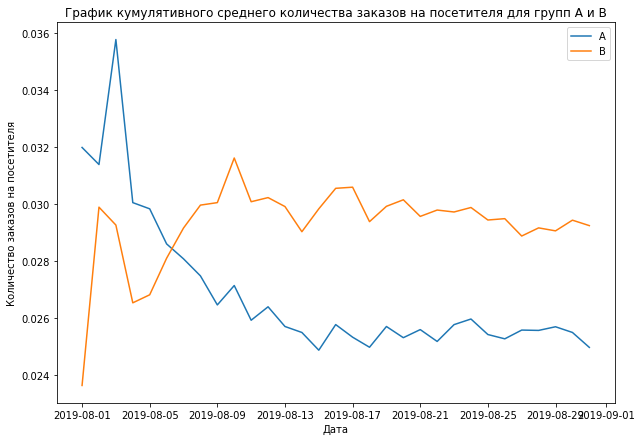

In [39]:
plt.figure(figsize=(10,7))
# Строим график выручки группы А
plt.plot(ord_vis_merged['date'], ord_vis_merged['conversionA'], label='A')

# Строим график выручки группы B
plt.plot(ord_vis_merged['date'], ord_vis_merged['conversionB'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя для групп А и В')
plt.xlabel('Дата')
plt.ylabel('Количество заказов на посетителя');

Как видно число заказов на посетителя в итоге для группы В заметно выше чем в А. В то же время вначале наблюдаются резкие скачки (возможно из-за аномально высокого числа заказов).

[к содержанию](#enter)

<a id='mean_ord_prop'></a>
### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

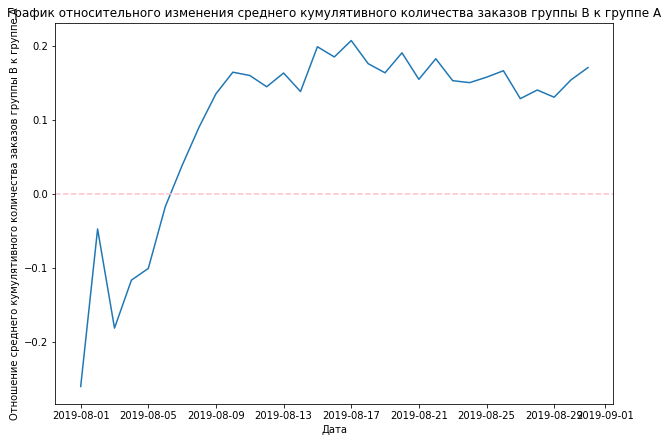

In [40]:
plt.figure(figsize=(10,7))
plt.plot(ord_vis_merged['date'], ord_vis_merged['conversionB']/ord_vis_merged['conversionA']-1)
plt.axhline(y=0, color='pink', linestyle='--')
plt.title('График относительного изменения среднего кумулятивного количества заказов группы В к группе А')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего кумулятивного количества заказов группы В к группе А');

Данный график также отражает резкое различие в числе заказов по группам. При этом в начале в группе А было на 27% больше заказов, потом разрыв сократился до 4% и снова увеличился до 18%. Далее после 3.08 наблюдается рост количества заказов в группе В по отношению к А до 15-20%.

[к содержанию](#enter)

<a id='scatter'></a>
### Точечный график количества заказов по пользователям.

Чтобы разобраться в причинах скачкообразных изменений параметров построим точечный график, на котором число заказов будет распределено между пользователями.

In [41]:
orders_number = orders.groupby('visitorId')['transactionId'].count().reset_index()
orders_number.columns=['userId', 'orders']

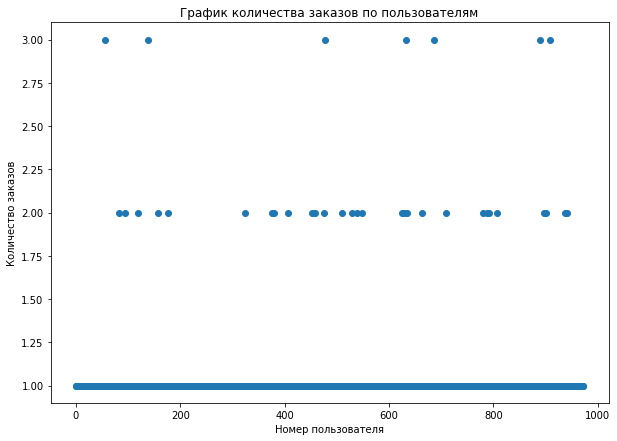

In [42]:
plt.figure(figsize=(10,7))
x_values=pd.Series(range(0, len(orders_number['userId'])))
plt.scatter(x_values, orders_number['orders'])
plt.title('График количества заказов по пользователям')
plt.xlabel('Номер пользователя')
plt.ylabel('Количество заказов');

Как видно, в основном пользователи приобрели по одному товару, затем идут те у кого 2 покупки, и далее 7 пользователей у которых число покупок равно трем.

[к содержанию](#enter)

<a id='perc_ord'></a>
### Расчет 95-й и 99-й перцентили количества заказов на пользователя. 

Для выбора границы аномальных пользователей по числу покупок найдем 95 и 99 перцентили.

In [43]:
print(np.percentile(orders_number['orders'], [95,99]))

[1. 2.]


Итак 95% пользователей совершили до одной покупки, а 99% - до 2х. В качестве границы аномальных заказов примем число покупок больше одной.

[к содержанию](#enter)

<a id='scatt_rev'></a>
### Точечный график стоимостей заказов.

Определим как заказы распределены по цене с помощью точечного графика.

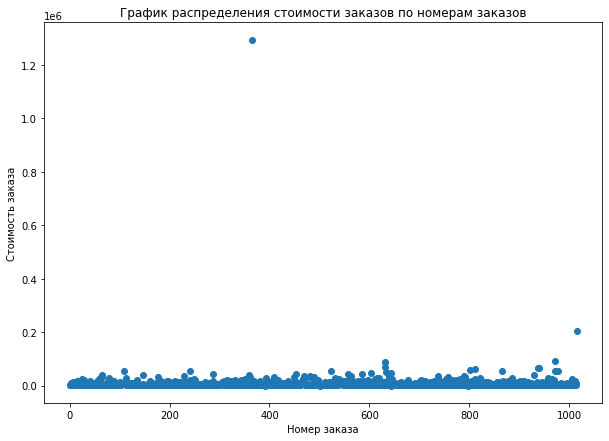

In [44]:
plt.figure(figsize=(10,7))
x_values=pd.Series(range(0, len(orders['transactionId'])))
plt.scatter(x_values, orders['revenue'])
plt.title('График распределения стоимости заказов по номерам заказов')
plt.xlabel('Номер заказа')
plt.ylabel('Стоимость заказа');

На графике видно, что очень мало заказов превышают 100000 р, а уж цена 200000 и 1300000 р встречается по 1 разу.

[к содержанию](#enter)

<a id='perc_rev'></a>
### Расчет 95-й и 99-й перцентили стоимости заказов. 

Для определения границы аномальных цен найдем 95 и 99 перцентили.

In [45]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


95% покупок стоят до 26785 р, а 99% - до 53904 р. Примем за границу аномалий - 26785 р.

[к содержанию](#enter)

<a id='ord_mwraw'></a>
### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Как было видно выше данные содержат выбросы, поэтому для снижения их влияния на статистическую значимость используем непараметрический тест Манна-Уитни. Примем за критический уровень статистической значимости 5%.

Начнем с расчета числа заказов на 1 пользователя.

In [46]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 

Чтобы учесть всех посетителей добавим к этим таблицам  пользователей без заказов.

In [47]:
sampleA=pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(
    visitorsA['visitors'].sum()-len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleB=pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(
    visitorsB['visitors'].sum()-len(ordersByUsersB['orders'])), name='orders')], axis=0)

Сформулируем гипотезы. <br/> *Нулевая - НО:* различий в среднем количестве заказов и среднем размере чека между группами нет.<br/>*Альтернативная - Н1:* различия между группами есть.

In [48]:
print('p-value: {0:0.3f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Превышение среднего числа заказов в группе В над А: {0:0.3f}'.format(sampleB.mean()/sampleA.mean()-1))

p-value: 0.011
Превышение среднего числа заказов в группе В над А: 0.160


Статистичская значимость равна 1,1%, что ниже чем 5%. Поэтому нулевую гипотезу о равенстве количества заказов на основе сырых данных можно отвергнуть. Среднее число заказов в группе В выше на 16%.

[к содержанию](#enter)

<a id='bill_mwraw'></a>
### Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным.

Для определения статистической значимости по среднему чеку также воспользумся тестом Манна-Уитни с границей 5%.

In [49]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Превышение среднего чека в группе В над А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value: 0.829
Превышение среднего чека в группе В над А: 0.287


Статистичекая значимость равна 82,9% значит нулевую гипотезу о равенстве среднего чека отвергнуть нельзя. Вместе с тем различие среднего чека на 28,7% не является статистически значимым (возможно из-за влияния выбросов).

[к содержанию](#enter)

<a id='ord_mwfilter'></a>
### Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Чтобы исключить влияние аномалий очистим их от 5% пользователей с наибольшим числом заказов и наиболее дорогими заказами. Сделаем срезы пользователей с числом заказов больше 2 — ubnormalOrders и пользователей, совершивших заказы дороже 28 000 — ubnormalrevenue. Объединим их в таблице ubnormal. 

In [50]:
ubnormalOrders=pd.concat([ordersByUsersA[ordersByUsersA['orders']>2]['userId'], ordersByUsersB[ordersByUsersB['orders']>2]['userId']], axis=0)
ubnormalrevenue=orders[orders['revenue']>28000]['visitorId']
ubnormal=pd.concat([ubnormalOrders, ubnormalrevenue], axis=0).drop_duplicates().sort_values()
ubnormal.shape[0]

55

Получилось 55 аномальных пользователей.

Отфильтруем данные от аномалий и создадим переменные с количеством заказов для всех посетителей.

In [51]:
sampleAFiltred=pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(ubnormal))]['orders'], pd.Series(0, index=np.arange(visitorsA['visitors'].sum()-len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleBFiltred=pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(ubnormal))]['orders'], pd.Series(0, index=np.arange(visitorsB['visitors'].sum()-len(ordersByUsersB['orders'])), name='orders')], axis=0)

In [52]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltred, sampleBFiltred)[1]))
print('Превышение среднего чека в группе В над А: {0:.3f}'.format(sampleBFiltred.mean()/sampleAFiltred.mean()-1)) 

p-value: 0.009
Превышение среднего чека в группе В над А: 0.189


Статистичекая значимость ниже критической (0,9%<5%) значит по очищенным данным нулевую гипотезу о равенстве количества заказов также можно отвергнуть. Среднее число заказов в группе В на 18,9% больше чем в группе А.

[к содержанию](#enter)

<a id='bill_mwfilter'></a>
### Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным.

Отфильтруем данные от аномалий и протестируем столбцы с выручкой по критерию Манна-Уитни.

In [53]:
print(
    'p-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(ubnormal)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(ubnormal)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Превышение среднего чека в группе В над А: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(ubnormal)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(ubnormal)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.762
Превышение среднего чека в группе В над А: -0.022


Как видно из результатов различий в среднем чеке почти нет, результаты являются статистически значимыми (p-value=76,2%) и
нулевую гипотезу о равенстве среднего чека по очищенным данным отвергнуть не получилось. 

[к содержанию](#enter)

<a id='conclusion'></a>
## Выводы.

1. Статистически значимого различия по размеру среднего чека в группах А и В не обнаружено.
2. По количеству заказов статистическое различие есть и среднее число заказов в группе В на 18,9% выше чем в А.
3. Графики кумулятивной выручки и числа заказов показыват, что результаты группы В лучше чем в группе А.
4. Исходя из обнаруженных фактов, тест следует остановить и признать успешным, зафиксировав победу группы В. 

[к содержанию](#enter)